<a href="https://colab.research.google.com/github/j-bull2003/timeseries_occupai/blob/main/timeseries_occupai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1 numpy==1.26.4 ultralytics==8.0.196 --quiet


In [2]:
from google.colab import files
import os, shutil

uploaded = files.upload()
os.makedirs('test', exist_ok=True)

# Rename uploaded images with timestamp labels
timestamps = ["08AM", "10AM", "02PM", "06PM"]
filenames = list(uploaded.keys())

for i in range(min(4, len(filenames))):
    shutil.move(filenames[i], f'test/{timestamps[i]}.png')


Saving 12836611-business-people-in-modern-office.jpg to 12836611-business-people-in-modern-office.jpg
Saving istockphoto-490850003-612x612.jpg to istockphoto-490850003-612x612.jpg
Saving istockphoto-1455632106-612x612.jpg to istockphoto-1455632106-612x612.jpg
Saving premium_photo-1683120730432-b5ea74bd9047.jpeg to premium_photo-1683120730432-b5ea74bd9047.jpeg


In [3]:

from ultralytics import YOLO

model = YOLO('yolov8n')

In [4]:
import numpy as np
from PIL import Image

image_data = {}

for time in ["08AM", "10AM", "02PM", "06PM"]:
    path = f'test/{time}.png'

    try:
        results = model.predict(source=path, conf=0.4, classes=0, save=False)
        result = results[0]
    except Exception as e:
        print(f"❌ Error predicting {time}: {e}")
        continue

    bbox_centers = []
    bbox_coords = []
    bbox_areas = []

    if result.boxes and result.boxes.xyxy is not None:
        boxes = result.boxes.xyxy.cpu().numpy()

        for box in boxes:
            x_min, y_min, x_max, y_max = box.astype(int)
            center_x = (x_min + x_max) // 2
            center_y = (y_min + y_max) // 2
            area = (x_max - x_min) * (y_max - y_min)
            bbox_centers.append([center_x, center_y])
            bbox_coords.append([x_min, y_min, x_max, y_max])
            bbox_areas.append(area)

    image_data[time] = {
        "bbox_centers": np.array(bbox_centers),
        "bbox_coords": bbox_coords,
        "bbox_areas": bbox_areas,
        "results": result
    }

    print(f"✅ {time} — {len(bbox_centers)} people detected.")



image 1/1 /content/test/08AM.png: 448x640 4 persons, 233.1ms
Speed: 24.4ms preprocess, 233.1ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)



✅ 08AM — 4 people detected.


image 1/1 /content/test/10AM.png: 544x640 6 persons, 261.6ms
Speed: 3.9ms preprocess, 261.6ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/test/02PM.png: 448x640 3 persons, 181.7ms
Speed: 3.6ms preprocess, 181.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)



✅ 10AM — 6 people detected.
✅ 02PM — 3 people detected.


image 1/1 /content/test/06PM.png: 448x640 6 persons, 184.6ms
Speed: 3.9ms preprocess, 184.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


✅ 06PM — 6 people detected.


In [6]:
from scipy.spatial import distance
import networkx as nx

for time in image_data:
    bbox_centers = image_data[time]["bbox_centers"]
    bbox_coords = image_data[time]["bbox_coords"]
    bbox_areas = image_data[time]["bbox_areas"]

    G = nx.Graph()
    for i in range(len(bbox_centers)):
        G.add_node(i)

    for i in range(len(bbox_centers)):
        for j in range(i + 1, len(bbox_centers)):
            dist = distance.euclidean(bbox_centers[i], bbox_centers[j])
            area_ratio = min(bbox_areas[i], bbox_areas[j]) / max(bbox_areas[i], bbox_areas[j])
            if 25 <= dist <= 150 and area_ratio >= 0.5:
                G.add_edge(i, j)

    group_components = [group for group in nx.connected_components(G) if len(group) > 1]

    # Load the original image again for drawing
    img = np.array(Image.open(f'test/{time}.png').convert("RGB"))

    # Draw group bounding boxes
    for group in group_components:
        idx = list(group)
        x_min = min(bbox_coords[i][0] for i in idx)
        y_min = min(bbox_coords[i][1] for i in idx)
        x_max = max(bbox_coords[i][2] for i in idx)
        y_max = max(bbox_coords[i][3] for i in idx)
        img = np.array(img)
        img[y_min:y_max, x_min] = [255, 0, 0]  # Left line
        img[y_min:y_max, x_max] = [255, 0, 0]  # Right line
        img[y_min, x_min:x_max] = [255, 0, 0]  # Top line
        img[y_max, x_min:x_max] = [255, 0, 0]  # Bottom line

    image_data[time]["grouped_image"] = img


In [8]:
import cv2

def create_density_heatmap(bbox_centers, shape, sigma=15):
    heatmap = np.zeros((shape[0], shape[1]), dtype=np.float32)
    for x, y in bbox_centers:
        heatmap[int(y), int(x)] += 1
    heatmap = cv2.GaussianBlur(heatmap, (0, 0), sigma)
    heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    return cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

for time in image_data:
    bbox_centers = image_data[time]["bbox_centers"]
    img = np.array(Image.open(f'test/{time}.png'))
    heatmap = create_density_heatmap(bbox_centers, img.shape[:2])
    image_data[time]["heatmap"] = heatmap



🕒 08AM – Group Detection:


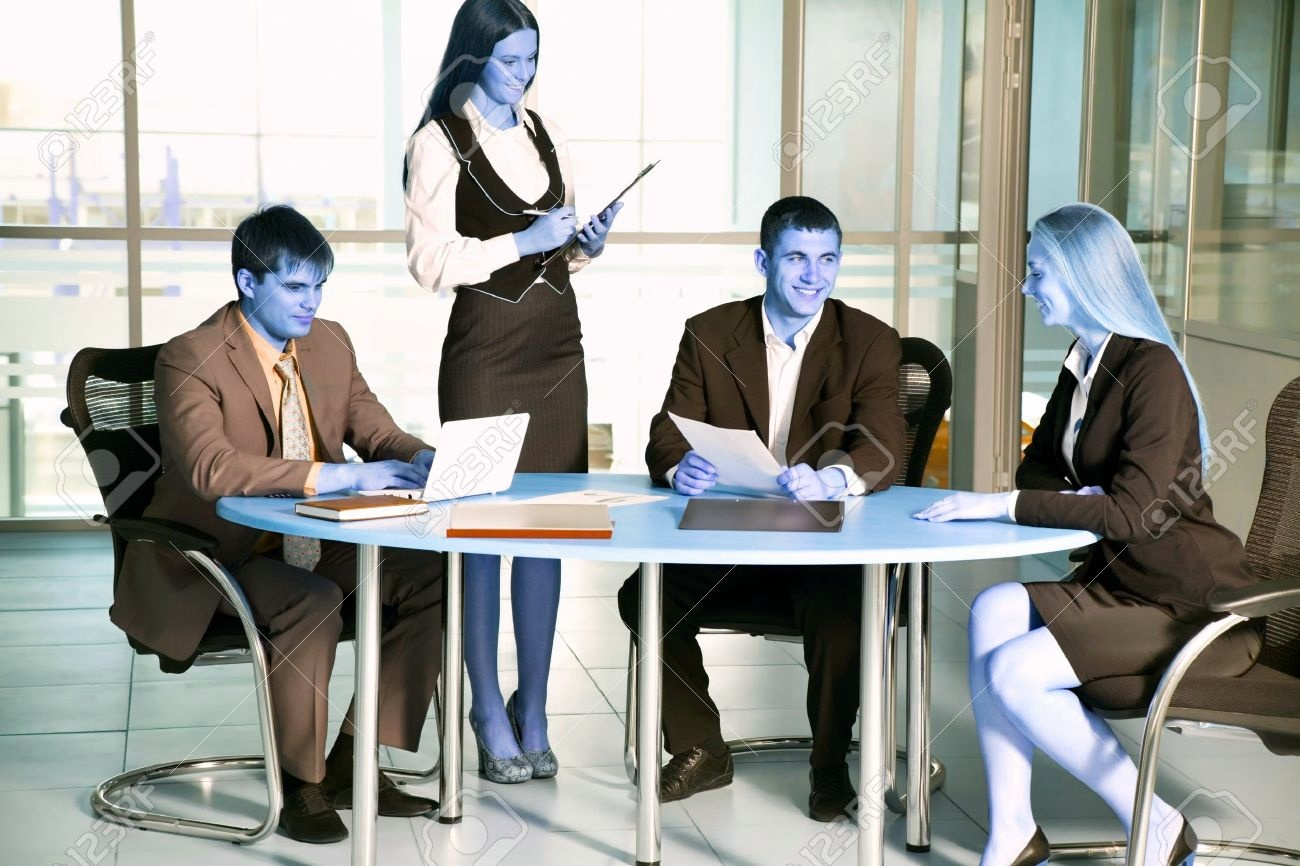

🌡️ 08AM – Density Heatmap:


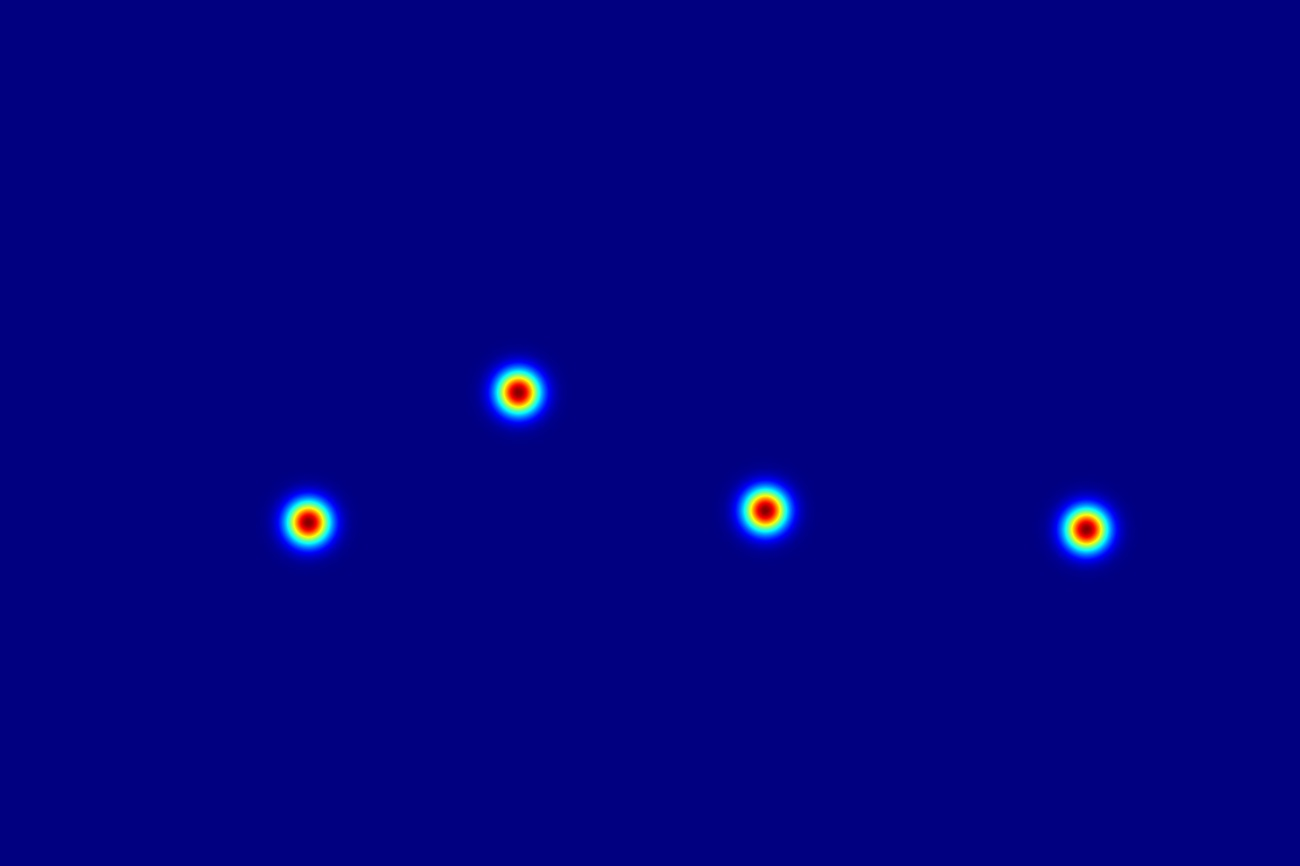


🕒 10AM – Group Detection:


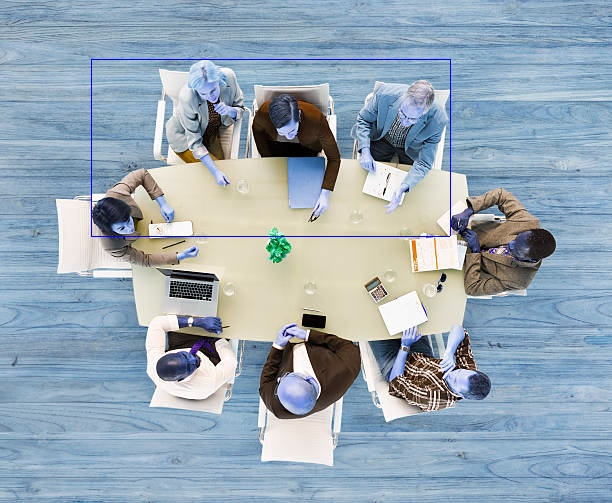

🌡️ 10AM – Density Heatmap:


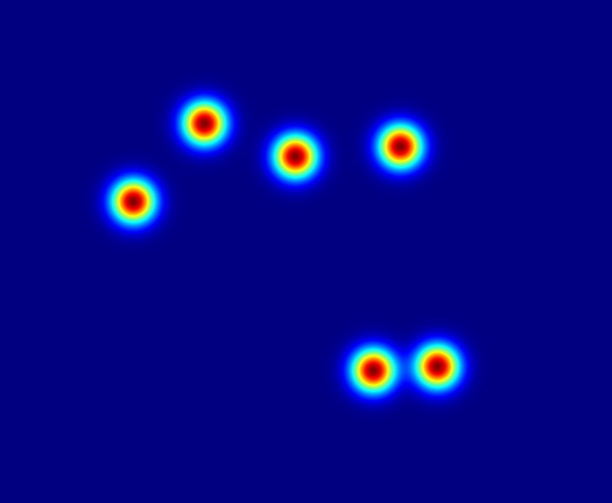


🕒 02PM – Group Detection:


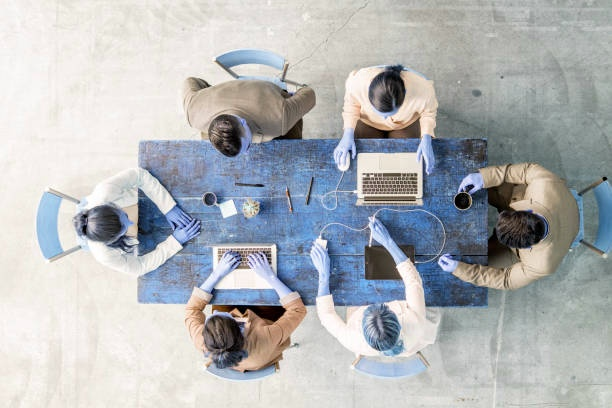

🌡️ 02PM – Density Heatmap:


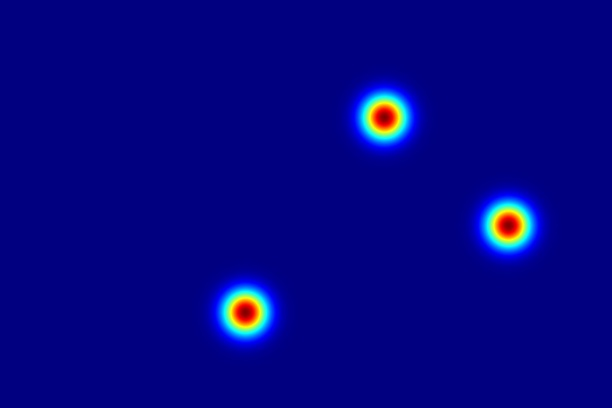


🕒 06PM – Group Detection:


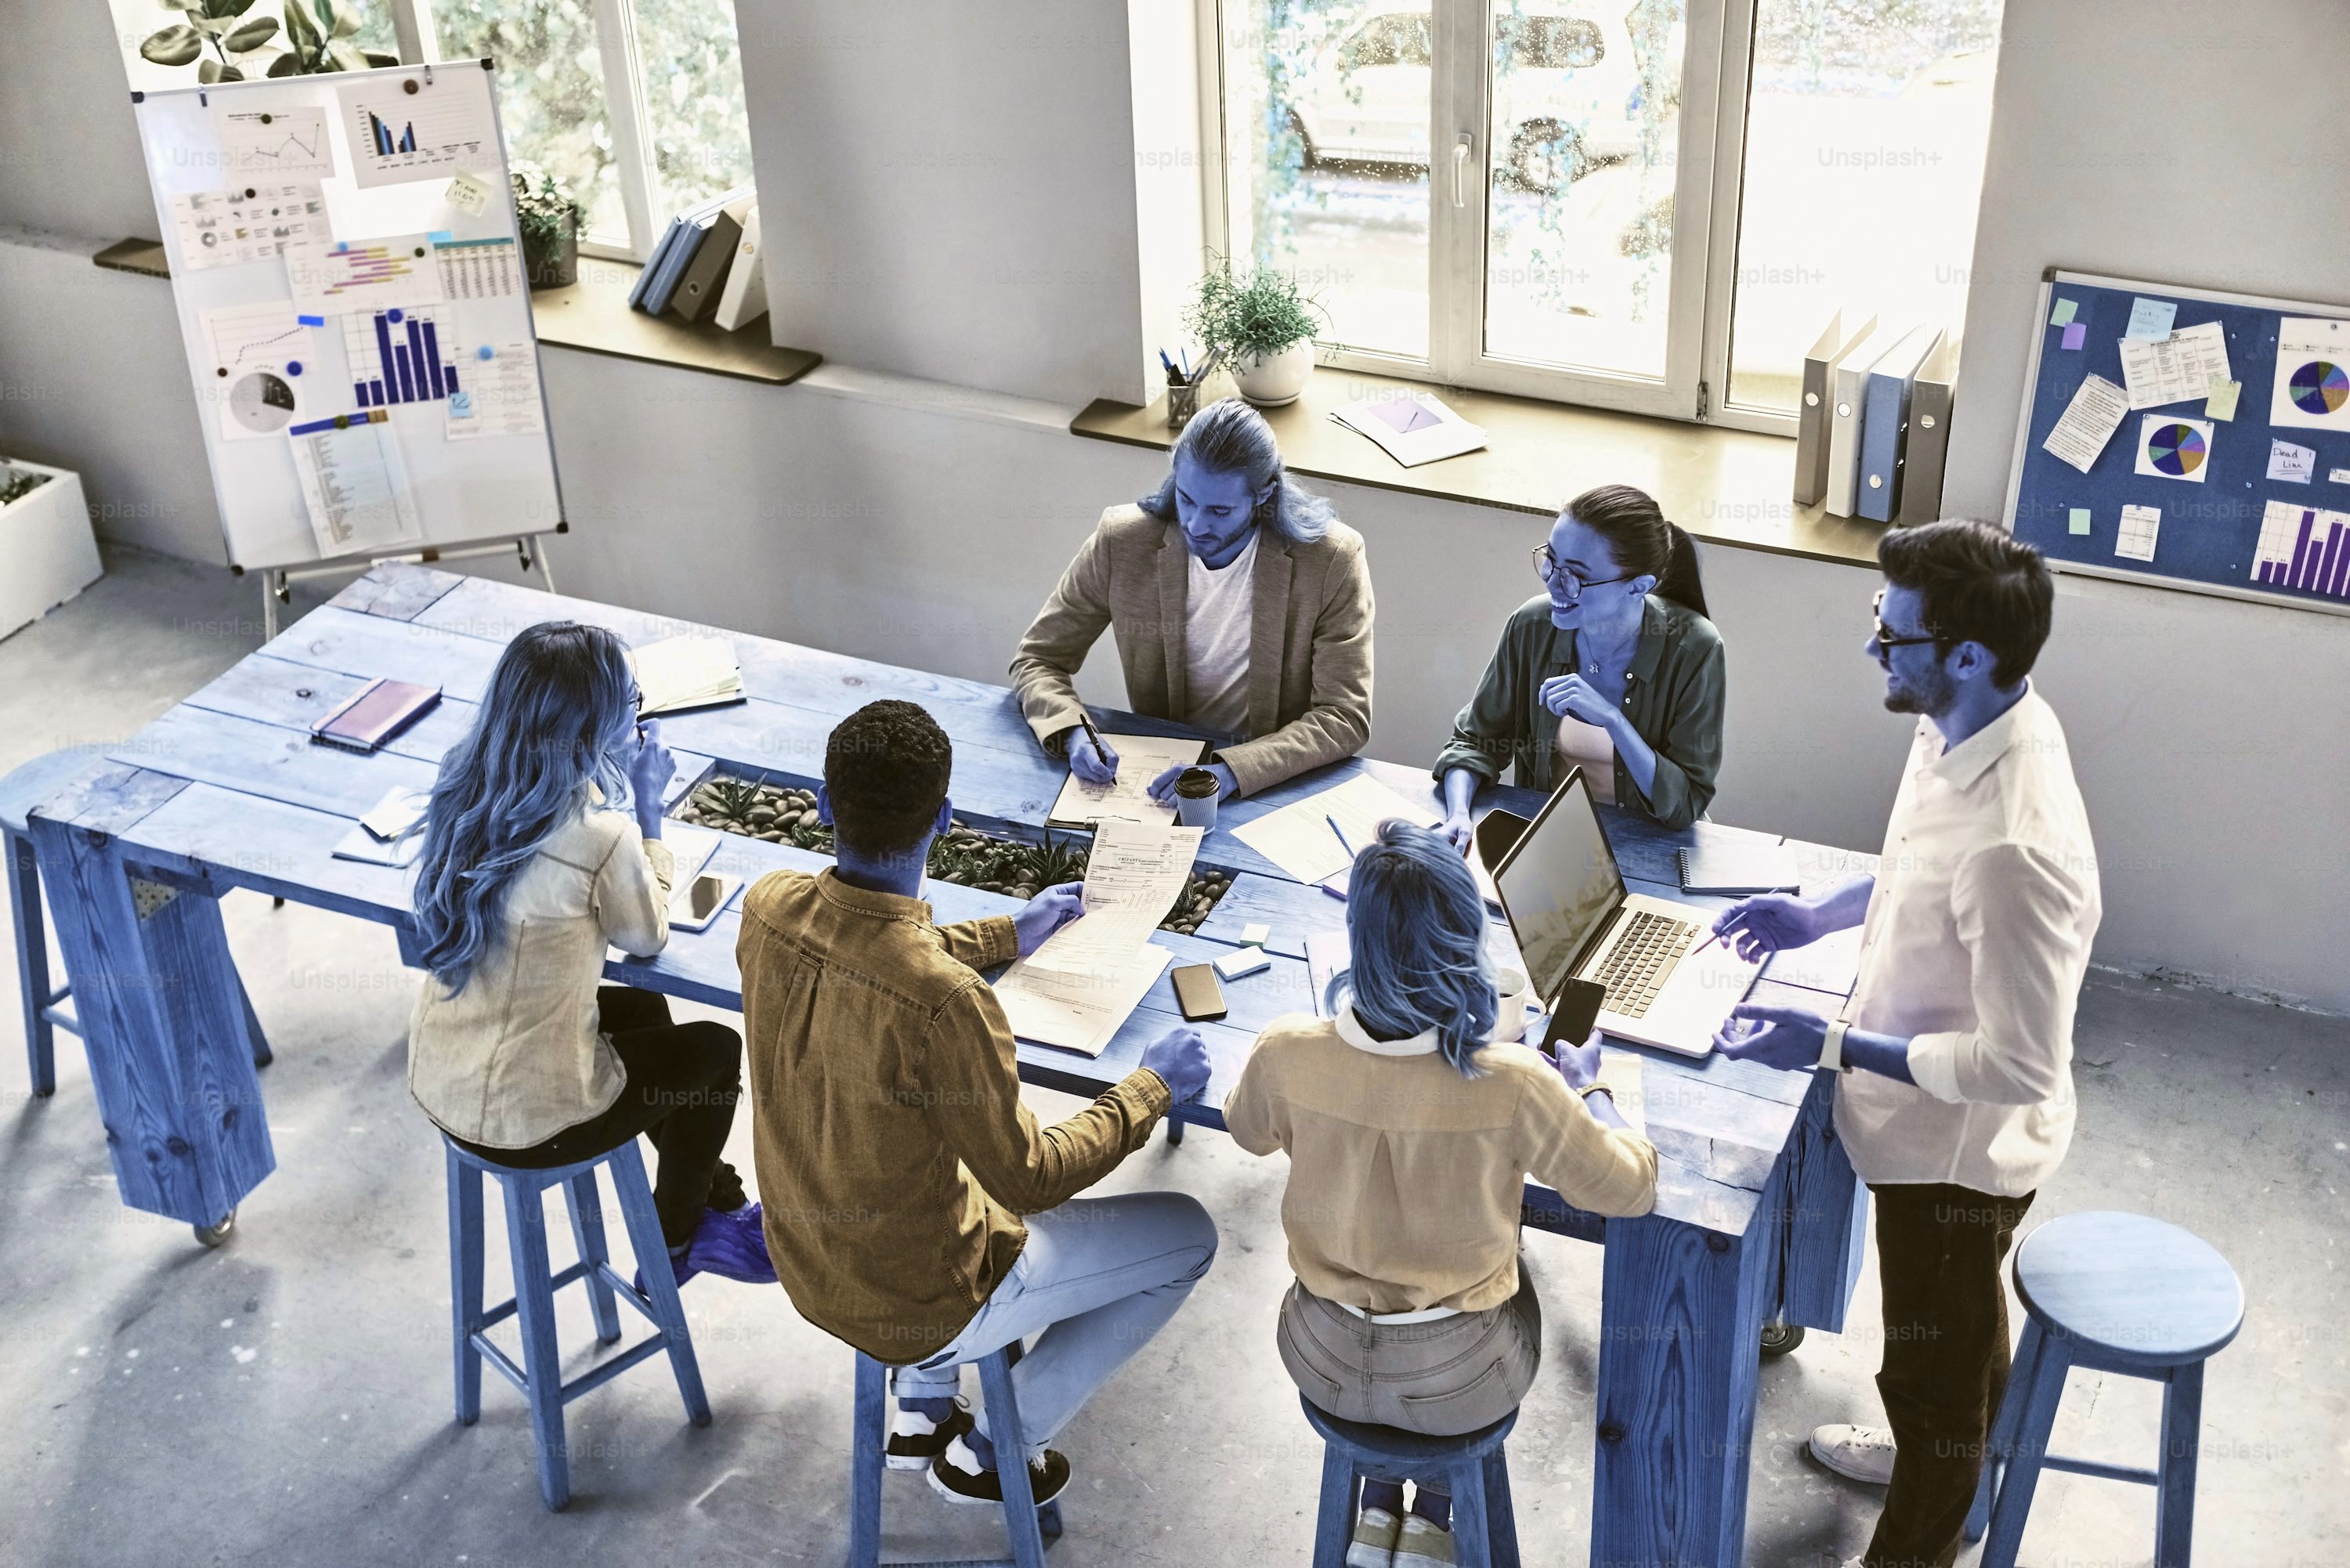

🌡️ 06PM – Density Heatmap:


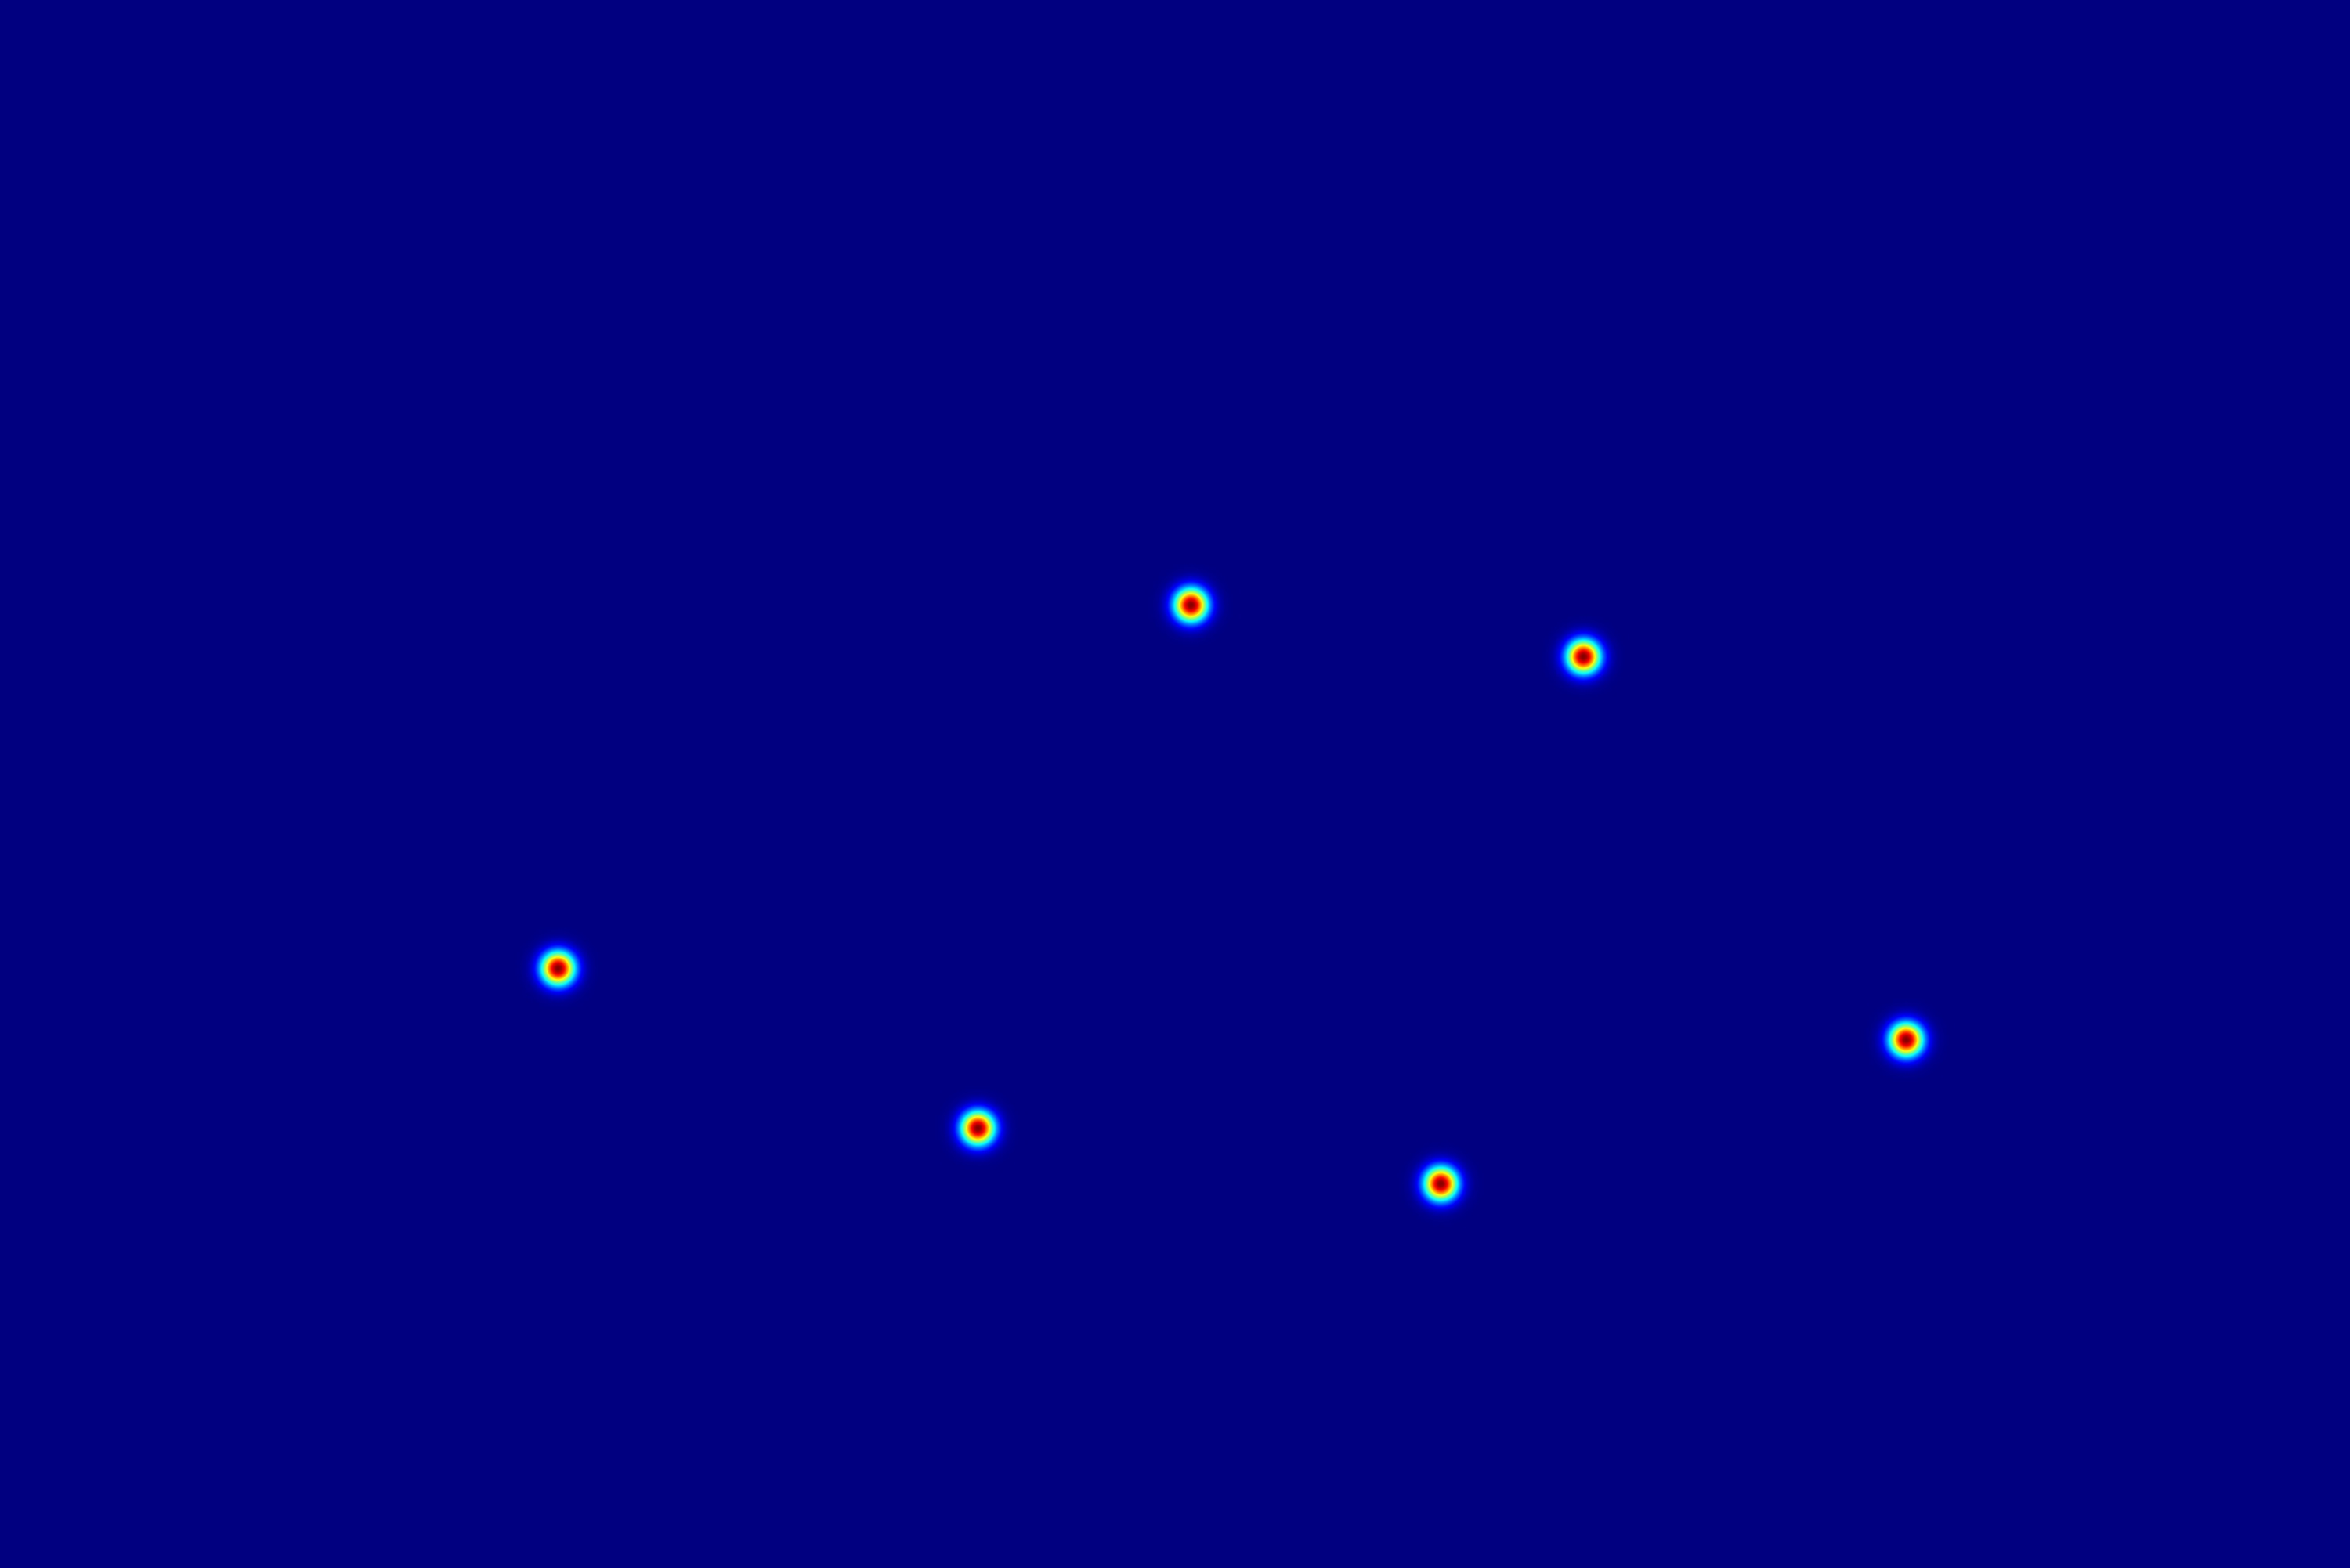

In [12]:
from IPython.display import Image as IPyImage, display
import cv2

# Save and display results
for time in image_data:
    grouped_path = f"{time}_grouped.jpg"
    heatmap_path = f"{time}_heatmap.jpg"

    cv2.imwrite(grouped_path, image_data[time]["grouped_image"])
    cv2.imwrite(heatmap_path, image_data[time]["heatmap"])

    print(f"\n🕒 {time} – Group Detection:")
    display(IPyImage(grouped_path))

    print(f"🌡️ {time} – Density Heatmap:")
    display(IPyImage(heatmap_path))


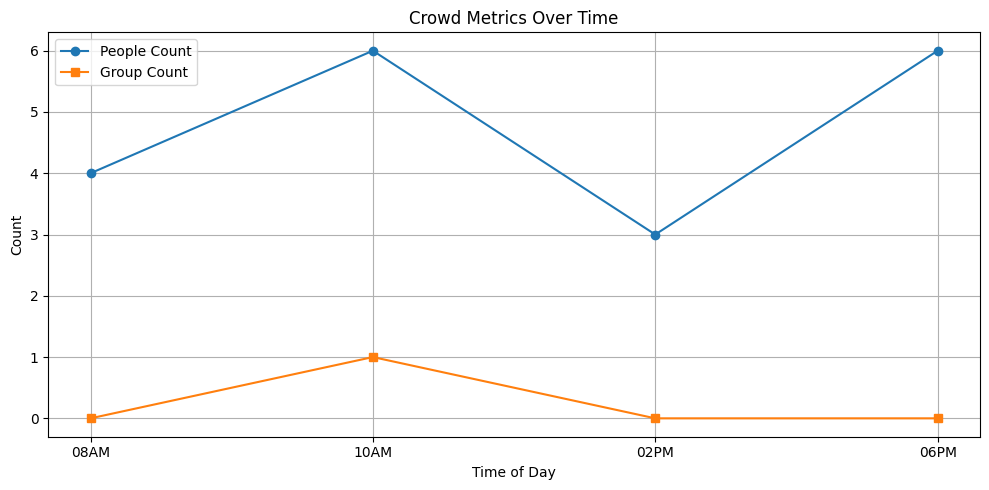

In [11]:
import matplotlib.pyplot as plt

# Prepare time-series data
timestamps = ["08AM", "10AM", "02PM", "06PM"]
people_counts = []
group_counts = []

for time in timestamps:
    if time in image_data:
        # Count people
        num_people = len(image_data[time]["bbox_centers"])
        people_counts.append(num_people)

        # Count groups from earlier step
        bbox_centers = image_data[time]["bbox_centers"]
        bbox_coords = image_data[time]["bbox_coords"]
        bbox_areas = image_data[time]["bbox_areas"]

        G = nx.Graph()
        for i in range(len(bbox_centers)):
            G.add_node(i)
        for i in range(len(bbox_centers)):
            for j in range(i + 1, len(bbox_centers)):
                dist = distance.euclidean(bbox_centers[i], bbox_centers[j])
                area_ratio = min(bbox_areas[i], bbox_areas[j]) / max(bbox_areas[i], bbox_areas[j])
                if 25 <= dist <= 150 and area_ratio >= 0.5:
                    G.add_edge(i, j)

        groups = [g for g in nx.connected_components(G) if len(g) > 1]
        group_counts.append(len(groups))
    else:
        people_counts.append(0)
        group_counts.append(0)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(timestamps, people_counts, marker='o', label='People Count')
plt.plot(timestamps, group_counts, marker='s', label='Group Count')
plt.title('Crowd Metrics Over Time')
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
!pip install influxdb-client --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.3/746.3 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 14.8 MB/s eta 0:00:00


In [19]:
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
import datetime

# 🔐 Replace these with your real InfluxDB Cloud credentials
influx_url = "https://us-east-1-1.aws.cloud2.influxdata.com"
influx_token = "tDXovw7zbw1w9OlsVbbhtpP_0XYA3I_vXC-X5RGuGcWMakPUSYZBQ8Jt5cMumPTO0L3gYCD8A5IlBHXVpDZNzg=="
influx_org = "OccupAI"
influx_bucket = "occupancy_data"

client = InfluxDBClient(url=influx_url, token=influx_token, org=influx_org)
write_api = client.write_api(write_options=SYNCHRONOUS)


In [28]:

from influxdb_client import Point
from datetime import datetime, timedelta

now = datetime.utcnow()
today = datetime.utcnow().date()  # Current UTC date, e.g., 2025-05-27
time_map = {
    "08AM": datetime.combine(today, datetime.min.time()) + timedelta(hours=8),
    "10AM": datetime.combine(today, datetime.min.time()) + timedelta(hours=10),
    "02PM": datetime.combine(today, datetime.min.time()) + timedelta(hours=14),
    "06PM": datetime.combine(today, datetime.min.time()) + timedelta(hours=18),
}

test_point = (
    Point("crowd_metrics")
    .tag("camera", "main")
    .field("people_count", 123)
    .field("group_count", 456)
    .time(now)
)

write_api.write(bucket="occupancy_data", org="OccupAI", record=test_point)
print("✅ Wrote test point at", now)



for time in timestamps:
    if time not in image_data:
        continue

    people_count = len(image_data[time]["bbox_centers"])

    # Rebuild group count using same graph logic
    bbox_centers = image_data[time]["bbox_centers"]
    bbox_coords = image_data[time]["bbox_coords"]
    bbox_areas = image_data[time]["bbox_areas"]

    G = nx.Graph()
    for i in range(len(bbox_centers)):
        G.add_node(i)
    for i in range(len(bbox_centers)):
        for j in range(i + 1, len(bbox_centers)):
            dist = distance.euclidean(bbox_centers[i], bbox_centers[j])
            area_ratio = min(bbox_areas[i], bbox_areas[j]) / max(bbox_areas[i], bbox_areas[j])
            if 25 <= dist <= 150 and area_ratio >= 0.5:
                G.add_edge(i, j)

    group_count = len([g for g in nx.connected_components(G) if len(g) > 1])
    print(f"📝 {time} | People: {people_count}, Groups: {group_count}")

    # Build and write the point
    point = (
        Point("crowd_metrics")
        .tag("camera", "main")  # Optional: tag your camera/location
        .field("people_count", people_count)
        .field("group_count", group_count)
        .time(time_map[time])
    )

    write_api.write(bucket=influx_bucket, org=influx_org, record=point)
    print(f"✅ Wrote {time} to InfluxDB: {people_count} people, {group_count} groups")


✅ Wrote test point at 2025-05-27 01:39:44.697312
📝 08AM | People: 4, Groups: 0
✅ Wrote 08AM to InfluxDB: 4 people, 0 groups
📝 10AM | People: 6, Groups: 1
✅ Wrote 10AM to InfluxDB: 6 people, 1 groups
📝 02PM | People: 3, Groups: 0
✅ Wrote 02PM to InfluxDB: 3 people, 0 groups
📝 06PM | People: 6, Groups: 0
✅ Wrote 06PM to InfluxDB: 6 people, 0 groups


In [29]:
query = f'''
from(bucket: "{influx_bucket}")
  |> range(start: -5m)
  |> filter(fn: (r) => r._measurement == "crowd_metrics")
  |> limit(n: 1)
'''

query_api = client.query_api()
tables = query_api.query(query, org=influx_org)

if tables:
    print("✅ Data is in InfluxDB.")
else:
    print("❌ No data found. Check bucket/token/org/measurement.")


✅ Data is in InfluxDB.
